In [29]:
import numpy as np
import torch
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from time import time
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

In [182]:
class MnistClassifier(torch.nn.Module):

    def __init__(self):
        super(MnistClassifier, self).__init__()

        self.features = torch.nn.Sequential(                    # inp: B 1 28 28
            torch.nn.Conv2d(1, 32, 3, stride=1, padding=0),     # B 32 26 26
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, 3, stride=1, padding=0),    # B 32 24 24
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=0),         # B 32 12 12
            torch.nn.Conv2d(32, 64, 3, stride=1, padding=0),    # B 64 10 10
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3, stride=1, padding=0),    # B 64 8 8
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=0),         # B 64 4 4
            torch.nn.Conv2d(64, 128, 3, stride=1, padding=0),   # B 128 2 2
            torch.nn.ReLU(),
        )

        self.decider = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4 * 128, 128),                      # B 128
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)                            # B 10
        )

        self.log_prob_cal = torch.nn.LogSoftmax(dim=-1)
        self.optimizer = torch.optim.Adam(filter(
            lambda p: p.requires_grad, self.parameters()), 
            lr=0.001
        )

        self.batch_x_placeholder = torch.zeros(size=[1, 1, 28, 28], dtype=torch.float32, device=torch.device('cuda:0'))
        self.batch_y_placeholder = torch.zeros(size=[1], dtype=torch.long, device=torch.device('cuda:0'))
    
    def forward(self, b_x, b_y=None):
        conv_features = self.features(b_x)
        class_scores = self.decider(conv_features.flatten(1))
        log_probs = self.log_prob_cal(class_scores)
        loss = -1 * torch.mean(log_probs[torch.arange(b_x.shape[0]), b_y])
        decision = torch.argmax(log_probs, dim=-1)
        return decision, loss
    
    def _forward(self, X, y=None):
        # resize placeholder
        if len(X) != len(self.batch_x_placeholder):
            self.batch_x_placeholder.resize_([len(X), 1, 28, 28])
            self.batch_y_placeholder.resize_([len(X)])
        
        self.batch_x_placeholder.copy_(torch.Tensor(X))
        if y is not None:
            self.batch_y_placeholder.copy_(torch.Tensor(y))

        b_decision, b_loss = self(self.batch_x_placeholder, self.batch_y_placeholder)

        if y is None:
            return b_decision
        return b_decision, b_loss
    
    def train_epoch(self, X_train, y_train, batch_size=32):
        self.train()

        iters_per_epoch = int(np.ceil(1.0 * len(X_train) / batch_size))

        # shuffling
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)

        epoch_loss = 0
        tps = 0

        # iterate over training set
        for iter in range(iters_per_epoch):
            batch_indices = indices[iter * batch_size: min(len(indices), (iter + 1) * batch_size)]

            # forward
            b_decision, b_loss = self._forward(X_train[batch_indices, :, :, :], y_train[batch_indices])
            b_decision = b_decision.cpu().numpy()

            epoch_loss += float(b_loss) / iters_per_epoch
            tps += np.sum(y_train[batch_indices].astype(int) == b_decision)

            b_loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()
            
        epoch_train_accuracy = tps * 100.0 / len(X_train)
        return epoch_loss, epoch_train_accuracy
    
    def evaluate(self, X, y=None, batch_size=32):
        with torch.no_grad():
            self.eval()

            iters_per_epoch = int(np.ceil(1.0 * len(X) / batch_size))

            indices = np.arange(len(X))

            predictions = []
            loss = 0
            tps = 0

            for iter in range(iters_per_epoch):
                batch_indices = indices[iter * batch_size: min(len(indices), (iter + 1) * batch_size)]

                if y is None:
                    b_decision = self._forward(X[batch_indices, :, :, :])
                else:
                    b_decision, b_loss = self._forward(X[batch_indices, :, :, :], y[batch_indices])

                b_decision = b_decision.cpu().numpy()

                if y is not None:
                    loss += float(b_loss) / iters_per_epoch
                    tps += np.sum(y[batch_indices].astype(int) == b_decision)
                else:
                    predictions.append(b_decision)

            if y is not None:
                accuracy = tps * 100.0 / len(X)
                return loss, accuracy
            
            return np.concatenate(predictions)

    def fit(self, X_train, y_train, epochs, batch_size):
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=40)

        train_loss = np.zeros((epochs,))
        val_loss = np.zeros((epochs,))
        train_acc = np.zeros((epochs,))
        val_acc = np.zeros((epochs,))

        val_iters_per_epoch = int(np.ceil(1.0 * len(X_val) / batch_size))

        for e in range(epochs):
            t_start = time()

            # train over dataset
            epoch_train_loss, epoch_train_accuracy = self.train_epoch(X_train, y_train, batch_size)
            train_loss[e] = epoch_train_loss
            train_acc[e] = epoch_train_accuracy

            # validating over validation set
            epoch_val_loss, epoch_val_accuracy = self.evaluate(X_val, y_val, batch_size)
            val_loss[e] = epoch_val_loss
            val_acc[e] = epoch_val_accuracy

            #saving model
            torch.save({
                    'epoch': e,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'model_state_dict': self.state_dict(),
                    'epoch_train_loss': epoch_train_loss,
                    'epoch_train_accuracy': epoch_train_accuracy,
                    'epoch_val_loss': epoch_val_loss,
                    'epoch_val_accuracy': epoch_val_accuracy
                }, f'epoch_{e}_state.pt')

            print(f'Epoch {e} finished in {time() - t_start:.2f}s. loss: {epoch_train_loss:.4f} - acc: {epoch_train_accuracy:.2f} - val loss: {epoch_val_loss:.4f} - val acc: {epoch_val_accuracy:.2f}')
        
        return train_loss, val_loss, train_acc, val_acc

In [183]:
mnist = fetch_openml('mnist_784')

In [184]:
X, y = mnist.data.reshape(70000, 1, 28, 28), mnist.target.astype(int)

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [190]:
model = MnistClassifier()
model = model.cuda()

In [191]:
batch_size = 64
epochs = 10

In [192]:
train_loss, val_loss, train_acc, val_acc = model.fit(X_train, y_train, epochs, batch_size)

Epoch 0 finished in 8.26s. loss: 0.2196 - acc: 93.14 - val loss: 0.0655 - val acc: 97.88
Epoch 1 finished in 8.21s. loss: 0.0731 - acc: 97.85 - val loss: 0.0621 - val acc: 98.20
Epoch 2 finished in 8.17s. loss: 0.0553 - acc: 98.36 - val loss: 0.0445 - val acc: 98.71
Epoch 3 finished in 8.15s. loss: 0.0487 - acc: 98.57 - val loss: 0.0551 - val acc: 98.71
Epoch 4 finished in 8.17s. loss: 0.0390 - acc: 98.83 - val loss: 0.0450 - val acc: 98.78
Epoch 5 finished in 8.14s. loss: 0.0338 - acc: 99.00 - val loss: 0.0466 - val acc: 98.73
Epoch 6 finished in 8.13s. loss: 0.0322 - acc: 99.05 - val loss: 0.0340 - val acc: 99.15
Epoch 7 finished in 8.15s. loss: 0.0329 - acc: 99.01 - val loss: 0.0370 - val acc: 99.13
Epoch 8 finished in 8.18s. loss: 0.0295 - acc: 99.13 - val loss: 0.0515 - val acc: 98.81
Epoch 9 finished in 8.13s. loss: 0.0266 - acc: 99.21 - val loss: 0.0383 - val acc: 98.91


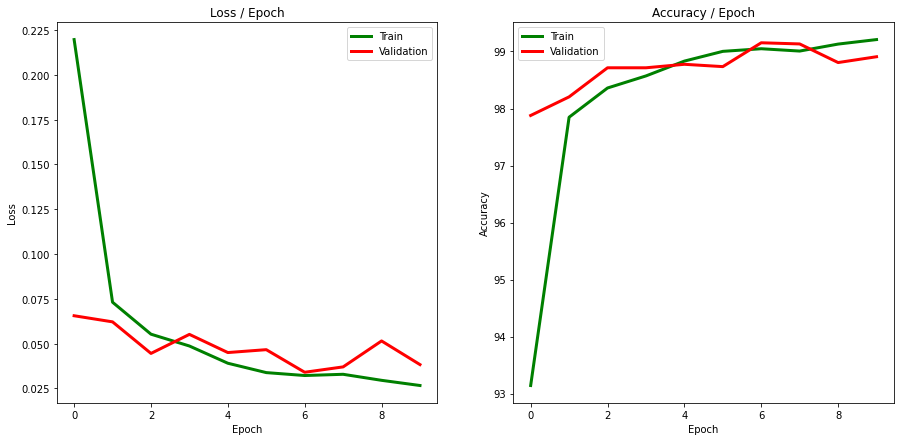

In [193]:
fig = plt.figure(figsize=(15, 7))

# loss
ax = fig.add_subplot(121)
ax.set_title('Loss / Epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='green', linewidth=3)
plt.plot(val_loss, label='Validation', color='red', linewidth=3)


plt.legend()

# acc
ax = fig.add_subplot(122)
ax.set_title('Accuracy / Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_acc, label='Train', color='green', linewidth=3)
plt.plot(val_acc, label='Validation', color='red', linewidth=3)


plt.legend()

In [194]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size)
print(f'Test loss: {test_loss:.4f} - Accuracy: {test_accuracy:.2f}')

Test loss: 0.0346 - Accuracy: 98.98


In [195]:
def draw(images, texts, columns=1, rows=1):
    fig = plt.figure(figsize=(2 * columns, 2 * rows))

    for i in range(columns * rows):
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.set_title(texts[i])
        ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(images[i].reshape((28, 28)))

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.show()

In [196]:
predictions = model.evaluate(X_test, batch_size=batch_size)
predictions.shape

(21000,)

Some right predictions:

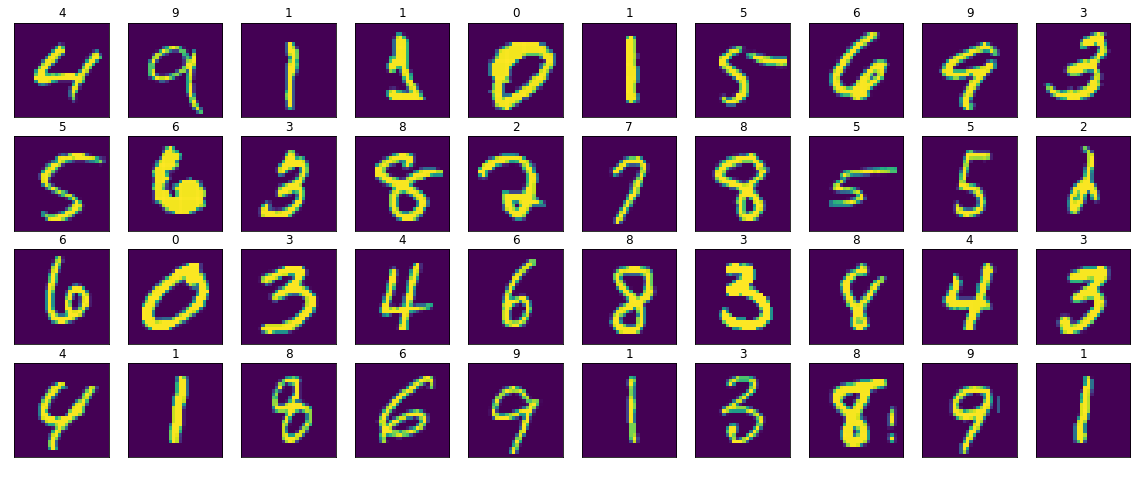

In [198]:
right_images = X_test[predictions == y_test]
right_labels = predictions[predictions == y_test]
right_indices = np.random.choice(np.arange(len(right_images)), size=40)

images = right_images[right_indices]
label_predictions = right_labels[right_indices]
texts = [f'{label_predictions[i]}' for i in range(len(right_indices))]

draw(images, texts, 10, 4)

Some wrong predictions:

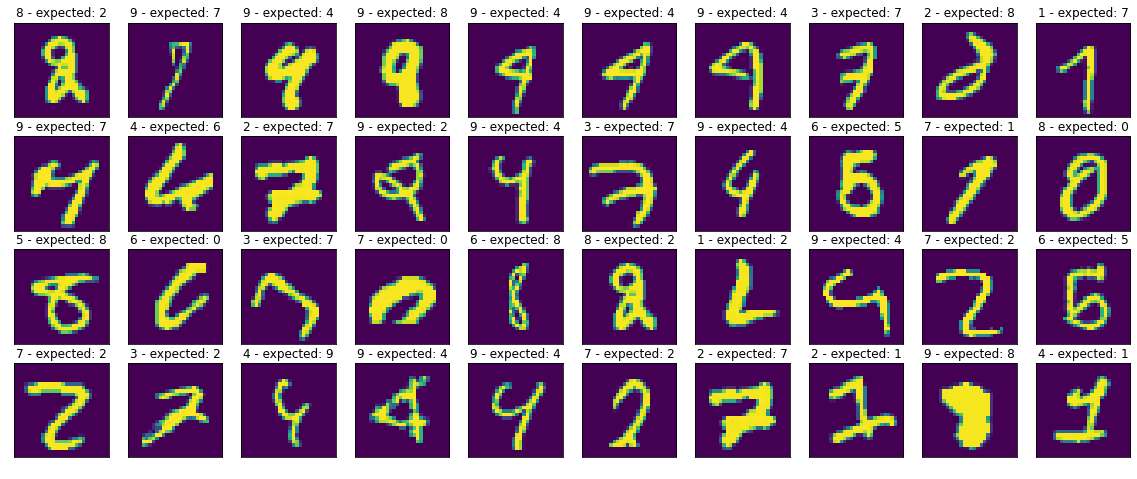

In [199]:
wrong_images = X_test[predictions != y_test]
wrong_labels = predictions[predictions != y_test]
right_labels = y_test[predictions != y_test]
wrong_indices = np.random.choice(np.arange(len(wrong_images)), size=40)

images = wrong_images[wrong_indices]
wrong_label_predictions = wrong_labels[wrong_indices]
right_label_predictions = right_labels[wrong_indices]
texts = [f'{wrong_label_predictions[i]} - expected: {right_label_predictions[i]}' for i in range(len(wrong_indices))]

draw(images, texts, 10, 4)

### AutoEncoder:

In [200]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        # self.encoder = torch.nn.Sequential(                                         # B 1   28  28
        #     torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),             # B 32  28  28
        #     torch.nn.ReLU(inplace=True),
        #     torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),            # B 32  28  28
        #     torch.nn.ReLU(inplace=True),
        #     torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                 # B 32  14  14
        # )
        
        # self.decoder = torch.nn.Sequential(
        #     torch.nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),            # B 16  14  14
        #     torch.nn.ReLU(inplace=True),
        #     torch.nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, padding=0),    # B 1   28  28
        #     torch.nn.Sigmoid()
        # )

        self.encoder = torch.nn.Sequential(                                         # B 1   28  28
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),             # B 32  26  26
            torch.nn.ELU(inplace=True),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),            # B 32  24  24
            torch.nn.ELU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                 # B 32  12  12
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),            # B 64  10   10
            torch.nn.ELU(inplace=True),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),            # B 64  8   8
            torch.nn.ELU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)                  # B 64  4   4
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0),   # B 64  8   8      
            torch.nn.ELU(inplace=True),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),   # B 32  16  16
            torch.nn.ELU(inplace=True),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0),   # B 16  32  32
            torch.nn.ELU(inplace=True),
            torch.nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=0),             # B 8   30  30
            torch.nn.ELU(inplace=True),
            torch.nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=0),              # B 1   28  28
            torch.nn.ELU()
        )

        self.optimizer = torch.optim.Adam(filter(
            lambda p: p.requires_grad, self.parameters()), 
            lr=0.01
        )

        self.loss_function = torch.nn.MSELoss()

        self.batch_placeholder = torch.zeros(size=[1, 1, 28, 28], dtype=torch.float32, device=torch.device('cuda:0'))

    def forward(self, batch):
        encoded = self.encoder(batch)
        reconstructed = self.decoder(encoded)

        loss = self.loss_function(reconstructed, batch)

        return reconstructed, loss

    def _forward(self, batch):
        # resize placeholder
        if len(batch) != len(self.batch_placeholder):
            self.batch_placeholder.resize_([len(batch), 1, 28, 28])
        
        self.batch_placeholder.copy_(torch.Tensor(batch))
        b_reconstructed, b_loss = self(self.batch_placeholder)

        return b_reconstructed, b_loss
    
    def _encode_forward(self, batch):
        #resize placeholder
        if len(batch) != len(self.batch_placeholder):
            self.batch_placeholder.resize_([len(batch), 1, 28, 28])
        
        self.batch_placeholder.copy_(torch.Tensor(batch))

        return self.encoder(self.batch_placeholder).flatten(1)

    def encode(self, X, batch_size=32):
        with torch.no_grad():
            self.eval()

            iters_per_epoch = int(np.ceil(1.0 * len(X) / batch_size))
            indices = np.arange(len(X))
            reconstructeds = []

            for iter in range(iters_per_epoch):
                batch_indices = indices[iter * batch_size: min(len(indices), (iter + 1) * batch_size)]
                b_reconstructed = self._encode_forward(X[batch_indices, :, :, :]).cpu().numpy()
                reconstructeds.append(b_reconstructed)                    
            
            return np.concatenate(reconstructeds)
    
    def train_epoch(self, X_train, batch_size=32):
        self.train()

        iters_per_epoch = int(np.ceil(1.0 * len(X_train) / batch_size))

        # shuffling
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)

        epoch_loss = 0

        # iterate over training set
        for iter in range(iters_per_epoch):
            batch_indices = indices[iter * batch_size: min(len(indices), (iter + 1) * batch_size)]

            # forward
            _, b_loss = self._forward(X_train[batch_indices, :, :, :])

            if iter % 50 == 0:
                print(f'    Iteration {iter:3d}. batch loss: {float(b_loss):.4e}')

            epoch_loss += float(b_loss) / iters_per_epoch

            b_loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()
            
        return epoch_loss
    
    def evaluate(self, X, batch_size=32):
        with torch.no_grad():
            self.eval()

            iters_per_epoch = int(np.ceil(1.0 * len(X) / batch_size))

            indices = np.arange(len(X))

            reconstructeds = []
            loss = 0

            for iter in range(iters_per_epoch):
                batch_indices = indices[iter * batch_size: min(len(indices), (iter + 1) * batch_size)]

                b_reconstructed, b_loss = self._forward(X[batch_indices, :, :, :])
                b_reconstructed = b_reconstructed.cpu().numpy()

                loss += float(b_loss) / iters_per_epoch
                reconstructeds.append(b_reconstructed)                    
            
            return np.concatenate(reconstructeds), loss

    def fit(self, X_train, epochs, batch_size):
        X_train, X_val = train_test_split(X_train, test_size=0.2)

        train_loss = np.zeros((epochs,))
        val_loss = np.zeros((epochs,))

        for e in range(epochs):
            t_start = time()

            # train over dataset
            epoch_train_loss = self.train_epoch(X_train, batch_size)
            train_loss[e] = epoch_train_loss

            # validating over validation set
            _, epoch_val_loss = self.evaluate(X_val, batch_size)
            val_loss[e] = epoch_val_loss

            #saving model
            torch.save({
                    'epoch': e,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'model_state_dict': self.state_dict(),
                    'epoch_train_loss': epoch_train_loss,
                    'epoch_val_loss': epoch_val_loss
                }, f'epoch_{e}_state.pt')

            print(f'Epoch {e} finished in {time() - t_start:.2f}s. loss: {epoch_train_loss:.4e} - val loss: {epoch_val_loss:.4e}')
        
        return train_loss, val_loss

In [201]:
real_train = X_train.astype('float32') / 255
real_test = X_test.astype('float32') / 255

In [202]:
autoencoder = Autoencoder().cuda()
autoencoder

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ELU(alpha=1.0, inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ELU(alpha=1.0, inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ELU(alpha=1.0, inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ELU(alpha=1.0, inplace=True)
    (2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ELU(alpha=1.0, inplace=True)
    (4): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (5): ELU(alpha=1.0, inplace=True)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  

In [203]:
batch_size = 128
epochs = 6

In [204]:
train_loss, val_loss = autoencoder.fit(real_train, epochs, batch_size)

    Iteration   0. batch loss: 9.5677e-02
    Iteration  50. batch loss: 6.7493e-02
    Iteration 100. batch loss: 5.6063e-02
    Iteration 150. batch loss: 5.0435e-02
    Iteration 200. batch loss: 3.9740e-02
    Iteration 250. batch loss: 3.4803e-02
    Iteration 300. batch loss: 3.2329e-02
Epoch 0 finished in 8.28s. loss: 5.3519e-02 - val loss: 3.2965e-02
    Iteration   0. batch loss: 3.1449e-02
    Iteration  50. batch loss: 2.9155e-02
    Iteration 100. batch loss: 2.6922e-02
    Iteration 150. batch loss: 2.6530e-02
    Iteration 200. batch loss: 2.2398e-02
    Iteration 250. batch loss: 2.3350e-02
    Iteration 300. batch loss: 1.9822e-02
Epoch 1 finished in 8.09s. loss: 2.5493e-02 - val loss: 2.2582e-02
    Iteration   0. batch loss: 2.1186e-02
    Iteration  50. batch loss: 2.1426e-02
    Iteration 100. batch loss: 2.0162e-02
    Iteration 150. batch loss: 2.0239e-02
    Iteration 200. batch loss: 1.6843e-02
    Iteration 250. batch loss: 1.7863e-02
    Iteration 300. batch l

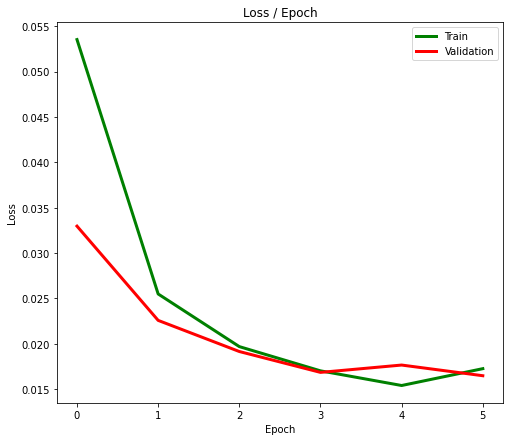

In [205]:
fig = plt.figure(figsize=(8, 7))

# loss
ax = fig.add_subplot(111)
ax.set_title('Loss / Epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='green', linewidth=3)
plt.plot(val_loss, label='Validation', color='red', linewidth=3)

plt.legend()

In [206]:
reconstructeds, test_loss = autoencoder.evaluate(real_test, batch_size)
test_loss

0.016160937370450216

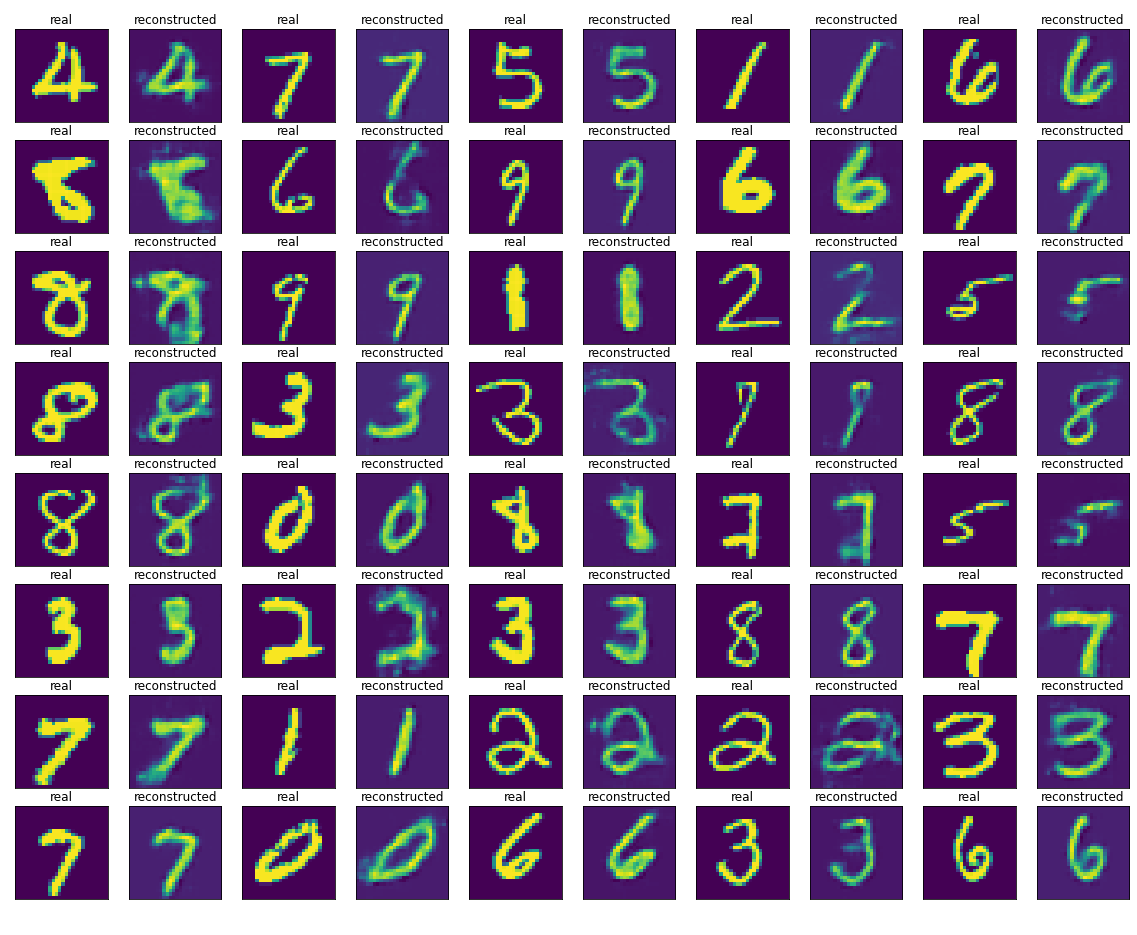

In [207]:
rows = 8
columns = 10
indices = np.random.choice(np.arange(len(X_test)), size=rows * columns // 2)
images = np.zeros((rows * columns // 2, 2, 28, 28))
images[:,0] = X_test[indices].reshape(rows * columns // 2, 28, 28)
images[:,1] = reconstructeds[indices].reshape(rows * columns // 2, 28, 28)
images = images.reshape(rows * columns, 28, 28) * 255

texts = np.zeros((rows * columns // 2, 2), dtype=object)
texts[:,0] = np.array(['real' for _ in range(rows * columns // 2)])
texts[:,1] = np.array(['reconstructed' for _ in range(rows * columns // 2)])
texts = texts.reshape(rows * columns)

draw(images, texts, columns, rows)

In [208]:
features = autoencoder.encode(real_test)
features.shape

(21000, 1024)

In [209]:
centers = np.zeros((10, 1024))

In [210]:
for label in range(10):
    centers[label] = features[y_test == label].mean(axis=0)

In [211]:
clustering = MiniBatchKMeans(n_clusters=10, batch_size=batch_size, verbose=2, init=centers, n_init=1)

In [212]:
_ = clustering.fit(features)

Init 1/1 with method: [[-0.9999805  -0.9993968  -0.73877424 ...  8.109127   14.3300705
   1.5642515 ]
 [-0.97353137 -0.86127925 -0.994618   ... -0.90003127 -0.8089772
  -0.9386243 ]
 [-0.9930129  -0.843247   -0.63337183 ...  2.6218      4.874011
   3.2795362 ]
 ...
 [-0.99999964 -0.99351734 -0.8440702  ...  3.482511    2.7193315
   0.6490767 ]
 [-0.99975073 -0.9975588  -0.86960554 ...  5.245786   15.919234
   5.144242  ]
 [-0.9999972  -0.9964412  -0.9218243  ...  5.1285934   7.635484
   0.7544159 ]]
Inertia for init 1/1: 25810224.000000
Minibatch iteration 1/16500: mean batch inertia: 70213.468750, ewa inertia: 70213.468750 
Minibatch iteration 2/16500: mean batch inertia: 72198.906250, ewa inertia: 70237.671026 
Minibatch iteration 3/16500: mean batch inertia: 72164.773438, ewa inertia: 70261.162204 
Minibatch iteration 4/16500: mean batch inertia: 69290.054688, ewa inertia: 70249.324504 
Minibatch iteration 5/16500: mean batch inertia: 71590.265625, ewa inertia: 70265.670437 
Minibat

In [213]:
matching_matrix = np.zeros((10, 10))

In [214]:
clusters = clustering.predict(features)
clusters.shape

Computing label assignment and total inertia


(21000,)

In [215]:
for cluster in range(10):
    for label in range(10):
        matching_matrix[cluster, label] = (y_test[clusters == cluster] == label).sum()

Text(0, 0.5, 'Cluster')

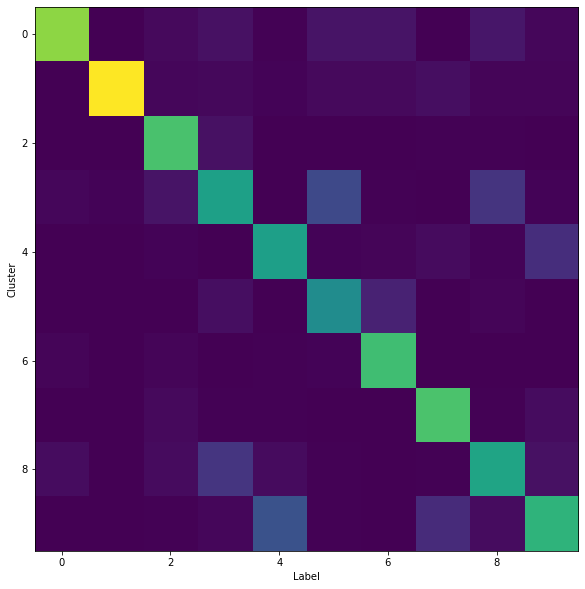

In [216]:
plt.figure(figsize=(10, 10))
plt.imshow(matching_matrix.astype(int))
plt.xlabel('Label')
plt.ylabel('Cluster')

In [225]:
print('accuracy:', np.diagonal(matching_matrix).sum() / matching_matrix.sum())

accuracy: 0.755095238095238
